In [1]:
import operator as op
import src.ea.ea_lib as ea
import src.ea.problem_data as pb
import src.ea.utilities as ut
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#EXPERIMENT 1: 

## CGP params
levels_back = 2
n_rows = 4
n_columns = 9
allow_input_to_output = False
inputs_available_to_all_columns = True
functions = [op.add,op.sub,op.mul,ut.safe_divide_one]

## MOEA params
rd.seed(4)
generations = 20
node_max_evals = 10000000
population_size = 200
tournament_size = 5
mutation_percentage = 9
problem_name = "spect"
objectives = [
    ea.Objective(name="acc0", to_max = True, best=1, worst=0),
    ea.Objective(name="acc1", to_max = True, best=1, worst=0)
    ]
generation_objective = ea.Objective(name="generation", to_max = True)
nsgaii_objectives = ea.get_nsgaii_objectives()
front_objective = nsgaii_objectives[0]
cd_objective = nsgaii_objectives[1]

## Definition
path = "NSGA-II_cgp/"
dataset = pb.Dataset()
dataset.load_problem(name = problem_name)
cgp = ea.CGP_Representation(
            dataset.x_train.shape[1]
            ,1
            ,levels_back
            ,n_rows 
            ,n_columns
            ,allow_input_to_output
            ,inputs_available_to_all_columns
            ,*functions)
labels = list(set(dataset.y_train))

def evaluate_ind(ind):
    outputs = {}
    for i,data_row in enumerate(dataset.x_train):
        output_dict = ind.representation.evaluate(data_row = data_row)
        #Extracting the 0th index output gene
        output = output_dict[0]
        #The raw output needs to be transformed
        #transformed_output = ut.custom_round(output)
        transformed_output = ut.threshold_map(value = output,threshold = 0.5, output_up = labels[1], output_down = labels[0])
        outputs[i] = transformed_output
    #Each objective has its own evaluation method
    acc0 = ut.accuracy_in_label(y = dataset.y_train, y_output = outputs, label = 0)
    acc1 = ut.accuracy_in_label(y = dataset.y_train, y_output = outputs, label = 1)
    ind.update_evaluation(objective = objectives[0], value = acc0)
    ind.update_evaluation(objective = objectives[1], value = acc1)
    ind.update_semantics_all(semantics_all = outputs)

def evaluate_population(population):
    for ind in population:
        evaluate_ind(ind)

def print_logs(population):
    evals0 = []
    evals1 = []
    actives = []
    gens = []
    for i,ind in enumerate(population):
        evals0.append(ind.evaluations[objectives[0].name])
        evals1.append(ind.evaluations[objectives[1].name])
        actives.append(len(ind.representation.active_genotype))
        gens.append(ind.evaluations["generation"])
    print("Best", max([evals0[i]+evals1[i] for i in range(len(population))]))
    print("Mean acc0", np.mean(evals0))
    print("Mean acc1", np.mean(evals1))
    print("Mean gen", np.mean(gens))
    print("Mean active nodes", np.mean(actives))
    print("Skips", len([i for i in population if i.representation.evaluation_skipped]))
    print(" ")



#Generation NSGA-II
def run_gen(population, current_gen):
    start_t = time.time()

    #Sort the population. The generation of creation is the latest tiebreak (suggested in CGP), so fast_nondominated_sort cannot be used as it is
    sorted_population = ea.fast_nondominated_sort(population = population, conflicting_objectives = objectives, nsgaii_objectives = nsgaii_objectives)

    #Logs (for previous gen)
    header, logs = ea.get_cgp_log(sorted_population, cgp)

    #Elitism
    parent_population = sorted_population[:population_size]

    #Offspring generation
    offspring_population = []
    for i in range(population_size):
        parent_index = ea.tournament_selection_index(population_size = len(parent_population), tournament_size = tournament_size)
        parent = parent_population[parent_index]
        new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
        offspring = ea.Individual(representation = new_graph)

        #If the active graph was not altered, the individual does not need to be evaluated again:
        if active_altered:
            evaluate_ind(offspring)
        else:
            offspring.representation.evaluation_skipped = True
            for objective in objectives:
                offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
            offspring.update_semantics_all(semantics_all = parent.semantics_all)
        offspring_population.append(offspring)

    #Update the gen_of_creation of the offsprings
    for offspring in offspring_population:
        offspring.update_evaluation(objective = generation_objective, value = current_gen)

    #Formation of the population for the next gen
    population = offspring_population + parent_population

    print("Gen " , str(current_gen), " time: ", str(time.time()-start_t))
    #print_logs(population)
    return population, header, logs

In [3]:
#Initial generation
generation = 0

#Random initial population. Specific initial conditions for the population can be specified here
graphs = [cgp.create_random(seed = rd.random()) for _ in range(population_size)]

#create instances of Individual to be grouped in the population
parent_population = [ea.Individual(r) for r in graphs]

#Evaluate and sort the population according to non-domination
evaluate_population(population = parent_population)
sorted_nsga2_population = ea.fast_nondominated_sort(population = parent_population, conflicting_objectives = objectives, nsgaii_objectives = nsgaii_objectives)

#Create the offsprings of the initial generation
population = parent_population
for i in range(population_size):

    #Binary tournament selection is used in the initial generation only according to NSGA-II. The offspring is evaluated and added to the population
    parent_index = ea.tournament_selection_index(population_size = population_size, tournament_size = 2)
    parent = sorted_nsga2_population[parent_index]
    new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
    offspring = ea.Individual(representation = new_graph)

    #If the active graph was not altered, the individual does not need to be evaluated again:
    if active_altered:
        evaluate_ind(offspring)
    else:
        offspring.representation.evaluation_skipped = True
        for objective in objectives:
            offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
        offspring.update_semantics_all(semantics_all = parent.semantics_all)
    population.append(offspring)

for ind in population:
    ind.update_evaluation(objective = generation_objective, value = generation)

In [4]:
individual_level_logs = []
#nodes_evaluated = 
for _ in range(generations+1):
    population, header, logs = run_gen(population, generation)

    #Logs
    individual_level_logs += logs

    #Plots
    if generation%20==0:
        ea.plot_pareto(population, objectives, "size", path = path, name = "plt_size_g"+str(generation))
        ea.plot_pareto(population, objectives, "color", path = path, name = "plt_color_g"+str(generation))
    generation += 1

    #stop_criteria:
    #for ind in population:


individual_level_logs.insert(0, header+["current_gen"])
ut.logs_to_file(individual_level_logs, "test_logs", path)

Gen  0  time:  1.6027414798736572
Gen  1  time:  1.4180474281311035
Gen  2  time:  1.4991860389709473
Gen  3  time:  1.3683104515075684
Gen  4  time:  1.3867442607879639
Gen  5  time:  1.3384859561920166
Gen  6  time:  1.4057583808898926
Gen  7  time:  1.6206715106964111
Gen  8  time:  1.5290775299072266
Gen  9  time:  1.5015556812286377
Gen  10  time:  1.5757229328155518
Gen  11  time:  1.3962945938110352
Gen  12  time:  1.5624101161956787
Gen  13  time:  1.618626594543457
Gen  14  time:  1.3045425415039062
Gen  15  time:  1.3793237209320068
Gen  16  time:  1.3669142723083496
Gen  17  time:  1.3574020862579346
Gen  18  time:  1.3653950691223145
Gen  19  time:  1.353104591369629
Gen  20  time:  1.4042081832885742


In [5]:
def run_gen_3crit(population, current_gen):
    start_t = time.time()

    #Sorting the population. The generation of creation is the latest tiebreak (suggested in CGP), so fast_nondominated_sort cannot be used as it is
    ea.set_ranks(population = population, conflicting_objectives = objectives, front_objective = front_objective)
    ea.set_crowding_distances_by_front(population = population, conflicting_objectives = objectives, front_objective = front_objective, cd_objective = cd_objective)
    sorted_population = ea.sort_population(population = population, objectives = [front_objective, cd_objective, generation_objective])


    #Elitism
    parent_population = sorted_population[:population_size]

    #Offspring generation
    offspring_population = []
    for i in range(population_size):
        parent_index = ea.tournament_selection_index(population_size = len(parent_population), tournament_size = tournament_size)
        parent = parent_population[parent_index]
        new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
        offspring = ea.Individual(representation = new_graph)

        #If the active graph was not altered, the individual does not need to be evaluated again:
        if active_altered:
            evaluate_ind(offspring)
        else:
            offspring.representation.evaluation_skipped = True
            for objective in objectives:
                offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
            offspring.update_semantics_all(semantics_all = parent.semantics_all)
        offspring_population.append(offspring)

    #Update the generation of creation of the offsprings
    for offspring in offspring_population:
        offspring.update_evaluation(objective = generation_objective, value = current_gen)

    #Formation of the population for the next gen
    population = offspring_population + parent_population

    print("Gen " , str(current_gen), " time: ", str(time.time()-start_t))
    #print_logs(population)
    return population


Gen  0  time:  2.110368251800537


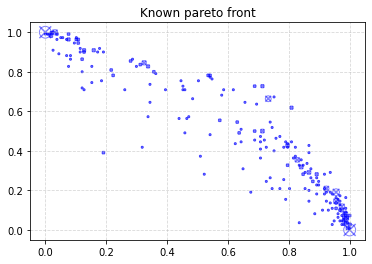

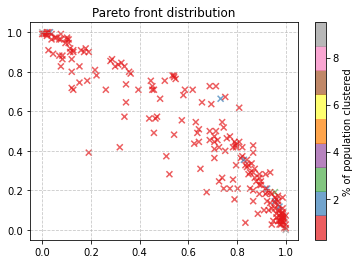

Gen  1  time:  2.0196022987365723
Gen  2  time:  1.690511703491211
Gen  3  time:  2.0786521434783936
Gen  4  time:  2.1223270893096924
Gen  5  time:  1.893946886062622
Gen  6  time:  1.9837234020233154
Gen  7  time:  1.9388210773468018
Gen  8  time:  1.8258485794067383
Gen  9  time:  1.9946422576904297
Gen  10  time:  2.204111099243164
Gen  11  time:  2.015611410140991
Gen  12  time:  1.968735694885254
Gen  13  time:  2.24456524848938
Gen  14  time:  2.125319480895996
Gen  15  time:  2.183176279067993
Gen  16  time:  2.2709290981292725
Gen  17  time:  2.3781821727752686
Gen  18  time:  2.139282703399658
Gen  19  time:  2.042511463165283
Gen  20  time:  2.2046706676483154
Gen  21  time:  2.2819011211395264
Gen  22  time:  2.3163461685180664
Gen  23  time:  2.246992826461792
Gen  24  time:  2.2789089679718018
Gen  25  time:  2.479372501373291
Gen  26  time:  2.3440611362457275
Gen  27  time:  2.2539708614349365
Gen  28  time:  2.129873752593994
Gen  29  time:  2.4055557250976562
Gen  30 

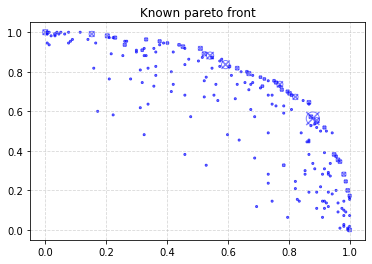

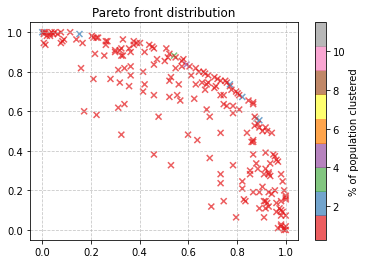

Gen  41  time:  2.2549924850463867
Gen  42  time:  2.3582637310028076
Gen  43  time:  2.2420101165771484
Gen  44  time:  2.2778878211975098
Gen  45  time:  2.3442606925964355
Gen  46  time:  2.4573991298675537
Gen  47  time:  2.3811795711517334
Gen  48  time:  2.338747024536133
Gen  49  time:  2.2260496616363525
Gen  50  time:  2.1861889362335205
Gen  51  time:  2.5078022480010986
Gen  52  time:  2.411553144454956
Gen  53  time:  2.260984420776367
Gen  54  time:  2.1931114196777344
Gen  55  time:  2.3537051677703857
Gen  56  time:  2.4025774002075195
Gen  57  time:  2.323821783065796
Gen  58  time:  2.268934965133667
Gen  59  time:  2.2110586166381836
Gen  60  time:  2.3328616619110107
Gen  61  time:  2.214082717895508
Gen  62  time:  2.3402228355407715
Gen  63  time:  2.268127202987671
Gen  64  time:  2.390166997909546
Gen  65  time:  2.020599365234375
Gen  66  time:  2.359255075454712
Gen  67  time:  2.2390506267547607
Gen  68  time:  2.2280402183532715
Gen  69  time:  2.665359258651

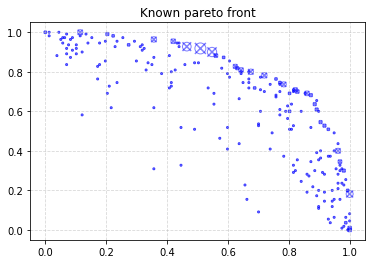

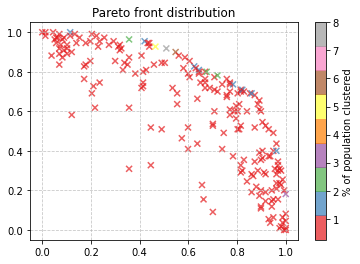

Gen  81  time:  2.0116288661956787
Gen  82  time:  2.101950168609619
Gen  83  time:  2.2060742378234863
Gen  84  time:  2.187222480773926
Gen  85  time:  2.1591861248016357
Gen  86  time:  2.2801456451416016
Gen  87  time:  2.239899158477783
Gen  88  time:  2.0089309215545654
Gen  89  time:  2.166111707687378
Gen  90  time:  2.2661798000335693
Gen  91  time:  2.2325668334960938
Gen  92  time:  2.1811153888702393
Gen  93  time:  2.2348403930664062
Gen  94  time:  2.251624822616577
Gen  95  time:  2.3915467262268066
Gen  96  time:  2.2309365272521973
Gen  97  time:  2.140280246734619
Gen  98  time:  2.47438645362854
Gen  99  time:  2.504331588745117
Gen  100  time:  2.250516414642334
Gen  101  time:  2.1691975593566895
Gen  102  time:  2.366151809692383
Gen  103  time:  2.325810194015503
Gen  104  time:  2.2108047008514404
Gen  105  time:  2.1223325729370117
Gen  106  time:  2.585649251937866
Gen  107  time:  2.2040789127349854
Gen  108  time:  2.2150838375091553
Gen  109  time:  2.18418

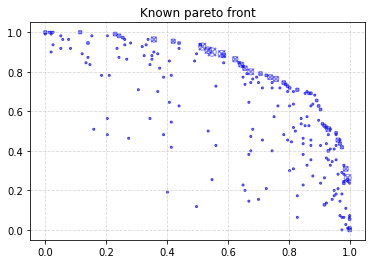

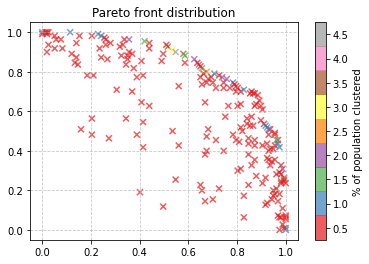

Gen  121  time:  2.099362373352051
Gen  122  time:  2.422549247741699
Gen  123  time:  2.1612226963043213
Gen  124  time:  2.4175143241882324
Gen  125  time:  2.071488618850708
Gen  126  time:  2.421497344970703
Gen  127  time:  2.2799012660980225
Gen  128  time:  2.212481737136841
Gen  129  time:  2.327775239944458
Gen  130  time:  2.2636475563049316
Gen  131  time:  2.1671905517578125
Gen  132  time:  2.2080962657928467
Gen  133  time:  2.483900308609009
Gen  134  time:  2.2440123558044434
Gen  135  time:  2.290067672729492
Gen  136  time:  2.2759130001068115
Gen  137  time:  2.336792469024658
Gen  138  time:  2.2758824825286865
Gen  139  time:  2.328197479248047
Gen  140  time:  2.075446367263794
Gen  141  time:  2.233003854751587
Gen  142  time:  2.3288049697875977
Gen  143  time:  2.027583122253418
Gen  144  time:  2.407074213027954
Gen  145  time:  2.4524455070495605
Gen  146  time:  2.2651479244232178
Gen  147  time:  2.2409777641296387
Gen  148  time:  2.4833598136901855
Gen  1

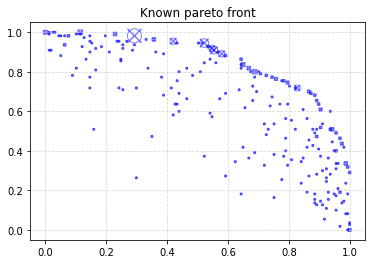

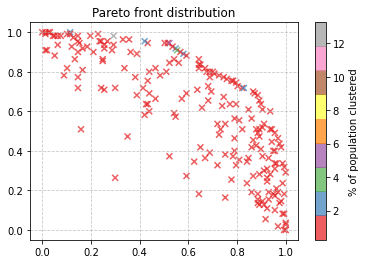

Gen  161  time:  2.375030279159546
Gen  162  time:  2.104607343673706
Gen  163  time:  1.9275856018066406
Gen  164  time:  2.0774481296539307
Gen  165  time:  2.0640978813171387
Gen  166  time:  1.9667112827301025
Gen  167  time:  2.0102086067199707
Gen  168  time:  2.2150485515594482
Gen  169  time:  2.067474126815796
Gen  170  time:  2.150800943374634
Gen  171  time:  2.1913836002349854
Gen  172  time:  2.1202239990234375
Gen  173  time:  1.9956953525543213
Gen  174  time:  1.9767978191375732
Gen  175  time:  2.0084922313690186
Gen  176  time:  2.0307183265686035
Gen  177  time:  2.0289876461029053
Gen  178  time:  1.9218645095825195
Gen  179  time:  1.9418106079101562
Gen  180  time:  2.0733518600463867
Gen  181  time:  1.9478764533996582
Gen  182  time:  1.9784049987792969
Gen  183  time:  2.1512506008148193
Gen  184  time:  2.1548404693603516
Gen  185  time:  1.920865535736084
Gen  186  time:  1.9507856369018555
Gen  187  time:  2.045037269592285
Gen  188  time:  2.006668090820312

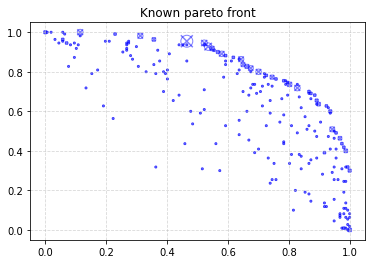

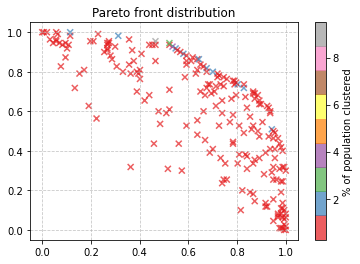

In [16]:
for _ in range(generations+1):
    population = run_gen_3crit(population, generation)
    if generation%40==0:
        ea.plot_pareto(population, objectives, "size")
        ea.plot_pareto(population, objectives, "color")
    generation += 1

In [17]:
import operator as op
import src.ea.ea_lib as ea
import src.ea.problem_data as pb
import src.ea.utilities as ut
import random as rd
import time
import numpy as np
import matplotlib.pyplot as plt

### Evolution strategy - vanilla CGP
rd.seed(1)
generations = 20000
population_size = 4
mutation_percentage = 9
problem_name = "spect"
objective = ea.Objective(name="acc", to_max = True, best=1, worst=0)
generation_objective = ea.Objective(name="generation", to_max = True)

#Setup
dataset = pb.Dataset()
dataset.load_problem(name = problem_name)

## CGP params
levels_back = 2
n_rows = 4
n_columns = 9
allow_input_to_output = False
inputs_available_to_all_columns = False
functions = [op.add,op.sub,op.mul,ut.safe_divide_one]

## Definition
dataset = pb.Dataset()
dataset.load_problem(name = problem_name)
cgp = ea.CGP_Representation(
            dataset.x_train.shape[1]
            ,1
            ,levels_back
            ,n_rows 
            ,n_columns
            ,allow_input_to_output
            ,inputs_available_to_all_columns
            ,*functions)
labels = list(set(dataset.y_train))

In [18]:
def evaluate_ind(ind):
    outputs = {}
    for i,data_row in enumerate(dataset.x_train):
        output_dict = ind.representation.evaluate(data_row = data_row)
        #Extracting the 0th index output gene
        output = output_dict[0]
        #The raw output needs to be transformed
        #transformed_output = ut.custom_round(output)
        transformed_output = ut.threshold_map(value = output,threshold = 0.5, output_up = labels[1], output_down = labels[0])
        outputs[i] = transformed_output
    #Each objective has its own evaluation method
    acc = ut.accuracy(y = dataset.y_train, y_output = outputs)
    ind.update_evaluation(objective, value = acc)
    ind.update_semantics_all(semantics_all = outputs)

def evaluate_population(population):
    for ind in population:
        evaluate_ind(ind)


In [19]:
### Evolution strategy - vanilla CGP

#Random initial population. Specific initial conditions for the population can be specified here
graphs = [cgp.create_random(seed = rd.random()) for _ in range(population_size)]

#create instances of Individual to be grouped in the population
population = [ea.Individual(r) for r in graphs]

#Evaluate and sort the population according to non-domination
evaluate_population(population)
for ind in population:
    ind.update_evaluation(objective = generation_objective, value = 0)
        

gen  0  acc  0.6217228464419475 actives  1
gen  500  acc  0.7565543071161048 actives  3
gen  1000  acc  0.7565543071161048 actives  4
gen  1500  acc  0.7640449438202247 actives  5
gen  2000  acc  0.7677902621722846 actives  5
gen  2500  acc  0.7677902621722846 actives  5
gen  3000  acc  0.7677902621722846 actives  5
gen  3500  acc  0.7752808988764045 actives  6
gen  4000  acc  0.7752808988764045 actives  6
gen  4500  acc  0.7752808988764045 actives  6
gen  5000  acc  0.7752808988764045 actives  6
gen  5500  acc  0.7865168539325843 actives  7
gen  6000  acc  0.7865168539325843 actives  7
gen  6500  acc  0.7865168539325843 actives  7
gen  7000  acc  0.7865168539325843 actives  7
gen  7500  acc  0.7865168539325843 actives  7
gen  8000  acc  0.7865168539325843 actives  7
gen  8500  acc  0.7940074906367042 actives  10
gen  9000  acc  0.7940074906367042 actives  10
gen  9500  acc  0.8052434456928839 actives  10
gen  10000  acc  0.8052434456928839 actives  10
gen  10500  acc  0.80524344569288

In [ ]:
for generation in range(generations):
    sorted_population = ea.sort_population(population,[objective, generation_objective])
    parent = sorted_population[0]
    population = [parent]

    #Create the offsprings of the initial generation
    for i in range(population_size-1):
        new_graph, active_altered = cgp.point_mutation(graph = parent.representation, percentage = mutation_percentage)
        offspring = ea.Individual(representation = new_graph)
        offspring.update_evaluation(objective = generation_objective, value = generation+1)

        #If the active graph was not altered, the individual does not need to be evaluated again:
        if active_altered:
            evaluate_ind(offspring)
        else:
            offspring.representation.evaluation_skipped = True
            offspring.update_evaluation(objective = objective, value = parent.evaluations[objective.name])
            offspring.update_semantics_all(semantics_all = parent.semantics_all)
        
        #add offspring to the population
        population.append(offspring)

    if generation%500==0:
        print("gen ", generation
        , " acc ", str(parent.evaluations[objective.name])
        , "actives ", str(len(parent.representation.active_genotype)))
        #print(parent.representation)
